<h3 align='center' style="color:purple;"> Import Necessary Libraries</h3>

In [25]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import torchvision.models as models
from torch.utils.data import DataLoader,random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import optuna
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Setting device as cuda if GPU is available

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

<h3 align='center' style="color:purple;"> Data Loading </h3>

In [27]:
image_transform= transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)), #Resizing Image
    transforms.ToTensor(), #Converting Image to tensor
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]) #Normalizing the tensors
])

In [28]:
dataset = datasets.ImageFolder('./dataset',transform= image_transform)

In [29]:
len(dataset)

2300

In [30]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

Creating Train Loader and Test Loader of batch size 32

In [31]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])  #Splitting dataset into training and validation
train_loader = DataLoader(train_dataset,shuffle = True,batch_size = 32)
val_loader = DataLoader(val_dataset,shuffle = True, batch_size = 32)

Plotting one sample image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..1.6988237].


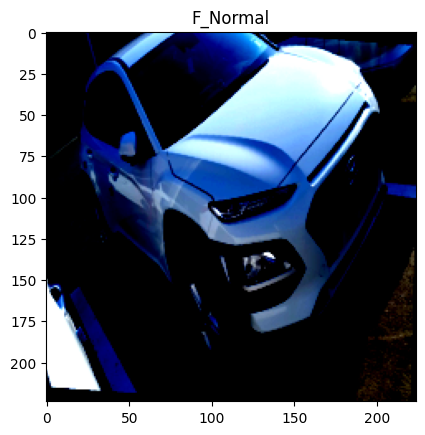

In [32]:
for images,labels in train_loader:
    plt.imshow(images[0].permute(1,2,0))
    plt.title(dataset.classes[labels[0].item()])
    plt.show()
    break

<h3 align = 'center' style="color: purple"> Model Training </h3>

### **1. CNN Model**

In [33]:
class DamageClassifier(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            #First Convolution Layer
            nn.Conv2d(in_channels = 3, out_channels=16,stride =1, kernel_size =3,padding = 'same'), # (3,224,224) ==> (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0), # (16,224,224) ==> (16,112,112)
            
            # Second Convulation Layer
            nn.Conv2d(in_channels = 16, out_channels=32,stride =1, kernel_size =3,padding = 'same'), # (16,112,112) ==> (32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0), # (32,112,112) ==> (32,56,56)

            # Third Convolution Layer
            nn.Conv2d(in_channels = 32, out_channels=64,stride =1, kernel_size =3,padding = 'same'), # (32,56,56) ==> (64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0), # (64,56,56) ==> (64,28,28)

            # Fully Connected Layers
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        ) 

    def forward(self,x):
        return self.network(x)

In [34]:
model = DamageClassifier(num_classes=6).to(device)  #Instantiating Damage Classifier
criterion = nn.CrossEntropyLoss().to(device) #Creating a Loss Function
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [35]:
def train_validate(model,criterion,optimizer,num_epochs):
    start = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for batch, (images,labels) in enumerate(train_loader):
            images,labels = images.to(device), labels.to(device)

            # Forward
            output = model(images)
            loss = criterion(output,labels)
            running_loss += loss.item() * images.size(0)
            optimizer.zero_grad()
            
            # Backward
            loss.backward()
            
            # Updation
            optimizer.step()
            if (batch+1) % 10 == 0:
                print(f"Batch {batch+1} Epoch {epoch+1} Loss {loss.item():.2f} ")  #Batch Loss after each 10th batch
                
        epoch_loss = running_loss /len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss {epoch_loss:.4f} ")   #Average Epoch Loss

        model.eval()
        total = 0
        correct = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels = images.to(device), labels.to(device)
                output = model(images)
                _,predicted = torch.max(output.data,1)  # Finiding index of maximum probability depicting resp. class.
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        print(f"**Validation Accuracy** {100*correct/total:.2f}%")
    end = time.time()
    print(f"Execution Time: {end-start}")
    return all_labels, all_predictions

In [36]:
all_labels,all_predictions = train_validate(model,criterion,optimizer,10)

Batch 10 Epoch 1 Loss 1.79 
Batch 20 Epoch 1 Loss 1.79 
Batch 30 Epoch 1 Loss 1.78 
Batch 40 Epoch 1 Loss 1.77 
Batch 50 Epoch 1 Loss 1.60 
Epoch 1/10, Average Loss 1.9714 
**Validation Accuracy** 38.43%
Batch 10 Epoch 2 Loss 1.39 
Batch 20 Epoch 2 Loss 1.09 
Batch 30 Epoch 2 Loss 1.27 
Batch 40 Epoch 2 Loss 1.08 
Batch 50 Epoch 2 Loss 1.00 
Epoch 2/10, Average Loss 1.2842 
**Validation Accuracy** 48.52%
Batch 10 Epoch 3 Loss 1.09 
Batch 20 Epoch 3 Loss 1.27 
Batch 30 Epoch 3 Loss 1.21 
Batch 40 Epoch 3 Loss 1.00 
Batch 50 Epoch 3 Loss 1.16 
Epoch 3/10, Average Loss 1.1216 
**Validation Accuracy** 53.74%
Batch 10 Epoch 4 Loss 1.04 
Batch 20 Epoch 4 Loss 0.89 
Batch 30 Epoch 4 Loss 1.01 
Batch 40 Epoch 4 Loss 0.95 
Batch 50 Epoch 4 Loss 0.98 
Epoch 4/10, Average Loss 1.0169 
**Validation Accuracy** 54.09%
Batch 10 Epoch 5 Loss 0.98 
Batch 20 Epoch 5 Loss 0.91 
Batch 30 Epoch 5 Loss 0.98 
Batch 40 Epoch 5 Loss 0.75 
Batch 50 Epoch 5 Loss 0.84 
Epoch 5/10, Average Loss 0.9089 
**Validatio

Insights:  
- After 10 epochs, the loss is significantly Minimized upto (0.6)
- Validation Accuracy is not much improved, oscillating in the range of (51-54)%
- Shows overfitting, as loss is reduced, but does not provide a better Accuracy
- We need to apply some regularizations to reduce overfitting.

### **2. CNN with Regularization**

In [37]:
class DamageClassifierwithReg(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            #First Convolution Layer
            nn.Conv2d(in_channels = 3, out_channels=16,stride =1, kernel_size =3,padding = 'same'), # (3,224,224) ==> (16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0), # (16,224,224) ==> (16,112,112)
            
            # Second Convulation Layer
            nn.Conv2d(in_channels = 16, out_channels=32,stride =1, kernel_size =3,padding = 'same'), # (16,112,112) ==> (32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0), # (32,112,112) ==> (32,56,56)

            # Third Convolution Layer
            nn.Conv2d(in_channels = 32, out_channels=64,stride =1, kernel_size =3,padding = 'same'), # (32,56,56) ==> (64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0), # (64,56,56) ==> (64,28,28)

            # Fully Connected Layers
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        ) 

    def forward(self,x):
        return self.network(x)

In [38]:
model = DamageClassifierwithReg(num_classes=6).to(device)  #Instantiating Damage Classifier with regularization
criterion = nn.CrossEntropyLoss().to(device) #Creating a Loss Function
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [39]:
all_labels,all_predictions = train_validate(model,criterion,optimizer,10)

Batch 10 Epoch 1 Loss 8.46 
Batch 20 Epoch 1 Loss 4.61 
Batch 30 Epoch 1 Loss 1.77 
Batch 40 Epoch 1 Loss 2.01 
Batch 50 Epoch 1 Loss 1.53 
Epoch 1/10, Average Loss 8.4823 
**Validation Accuracy** 35.48%
Batch 10 Epoch 2 Loss 1.76 
Batch 20 Epoch 2 Loss 1.22 
Batch 30 Epoch 2 Loss 1.50 
Batch 40 Epoch 2 Loss 1.50 
Batch 50 Epoch 2 Loss 1.45 
Epoch 2/10, Average Loss 1.4683 
**Validation Accuracy** 47.30%
Batch 10 Epoch 3 Loss 1.34 
Batch 20 Epoch 3 Loss 1.47 
Batch 30 Epoch 3 Loss 1.25 
Batch 40 Epoch 3 Loss 1.27 
Batch 50 Epoch 3 Loss 1.39 
Epoch 3/10, Average Loss 1.3480 
**Validation Accuracy** 49.39%
Batch 10 Epoch 4 Loss 1.42 
Batch 20 Epoch 4 Loss 1.25 
Batch 30 Epoch 4 Loss 1.14 
Batch 40 Epoch 4 Loss 1.48 
Batch 50 Epoch 4 Loss 1.23 
Epoch 4/10, Average Loss 1.2757 
**Validation Accuracy** 50.26%
Batch 10 Epoch 5 Loss 1.27 
Batch 20 Epoch 5 Loss 1.52 
Batch 30 Epoch 5 Loss 1.35 
Batch 40 Epoch 5 Loss 1.19 
Batch 50 Epoch 5 Loss 1.30 
Epoch 5/10, Average Loss 1.2092 
**Validatio

Insights:  
- After applying regularization loss is not that much reduced.
- Received less accuracy(45%) than the previous training which is done without regularization.
- The possible reason can be a smaller training size
- Need to do Transfer Learning

### 3. Pre-trained Model: Efficient Net

In [40]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes = 6):
        super().__init__()
        self.model = models.efficientnet_b0(weights ='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False
            
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )

    def forward(self,x):
        return self.model(x)

In [41]:
model = CarClassifierEfficientNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 0.001)
all_labels,all_predictions = train_validate(model,criterion,optimizer,10)


Batch 10 Epoch 1 Loss 1.67 
Batch 20 Epoch 1 Loss 1.45 
Batch 30 Epoch 1 Loss 1.69 
Batch 40 Epoch 1 Loss 1.34 
Batch 50 Epoch 1 Loss 1.33 
Epoch 1/10, Average Loss 1.4672 
**Validation Accuracy** 57.22%
Batch 10 Epoch 2 Loss 1.27 
Batch 20 Epoch 2 Loss 1.24 
Batch 30 Epoch 2 Loss 1.08 
Batch 40 Epoch 2 Loss 1.14 
Batch 50 Epoch 2 Loss 1.25 
Epoch 2/10, Average Loss 1.1240 
**Validation Accuracy** 64.70%
Batch 10 Epoch 3 Loss 1.16 
Batch 20 Epoch 3 Loss 1.11 
Batch 30 Epoch 3 Loss 0.99 
Batch 40 Epoch 3 Loss 0.93 
Batch 50 Epoch 3 Loss 1.02 
Epoch 3/10, Average Loss 1.0162 
**Validation Accuracy** 63.30%
Batch 10 Epoch 4 Loss 0.99 
Batch 20 Epoch 4 Loss 0.92 
Batch 30 Epoch 4 Loss 0.99 
Batch 40 Epoch 4 Loss 0.93 
Batch 50 Epoch 4 Loss 0.92 
Epoch 4/10, Average Loss 0.9374 
**Validation Accuracy** 65.39%
Batch 10 Epoch 5 Loss 0.99 
Batch 20 Epoch 5 Loss 0.88 
Batch 30 Epoch 5 Loss 0.79 
Batch 40 Epoch 5 Loss 0.84 
Batch 50 Epoch 5 Loss 0.93 
Epoch 5/10, Average Loss 0.9152 
**Validatio

Insights 
- Accuracy improved bit,reached to 66%.
- Loss is same as the previous models.

### 4. Pre-Trained Model: RestNet 50

In [42]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes = 6):
        super().__init__()
        self.model = models.resnet50(weights = 'DEFAULT')

        in_features = self.model.fc.in_features

        for param in self.model.parameters():
            param.requires_grad= False 
            
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        return self.model(x)

In [43]:
model = CarClassifierResNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 0.001)
all_labels,all_predictions = train_validate(model,criterion,optimizer,10)

Batch 10 Epoch 1 Loss 1.18 
Batch 20 Epoch 1 Loss 0.66 
Batch 30 Epoch 1 Loss 0.74 
Batch 40 Epoch 1 Loss 1.09 
Batch 50 Epoch 1 Loss 0.76 
Epoch 1/10, Average Loss 0.9167 
**Validation Accuracy** 74.43%
Batch 10 Epoch 2 Loss 0.50 
Batch 20 Epoch 2 Loss 0.35 
Batch 30 Epoch 2 Loss 0.69 
Batch 40 Epoch 2 Loss 0.50 
Batch 50 Epoch 2 Loss 0.34 
Epoch 2/10, Average Loss 0.4917 
**Validation Accuracy** 77.04%
Batch 10 Epoch 3 Loss 0.23 
Batch 20 Epoch 3 Loss 0.68 
Batch 30 Epoch 3 Loss 0.12 
Batch 40 Epoch 3 Loss 0.24 
Batch 50 Epoch 3 Loss 0.39 
Epoch 3/10, Average Loss 0.3373 
**Validation Accuracy** 80.00%
Batch 10 Epoch 4 Loss 0.10 
Batch 20 Epoch 4 Loss 0.23 
Batch 30 Epoch 4 Loss 0.12 
Batch 40 Epoch 4 Loss 0.26 
Batch 50 Epoch 4 Loss 0.21 
Epoch 4/10, Average Loss 0.2667 
**Validation Accuracy** 80.52%
Batch 10 Epoch 5 Loss 0.30 
Batch 20 Epoch 5 Loss 0.19 
Batch 30 Epoch 5 Loss 0.11 
Batch 40 Epoch 5 Loss 0.05 
Batch 50 Epoch 5 Loss 0.40 
Epoch 5/10, Average Loss 0.1925 
**Validatio

Insight:
- Accuracy reached to 75%, and  that's descent
- Need to do some hyper parameter tuning

<h3 align = 'center' style ='color: purple'> Hyperparameter Tuning </h3>

### Optuna

In [44]:
class CarClassifierResNet(nn.Module):
    def __init__(self,dropout_rate,num_classes = 6):
        super().__init__()
        self.model = models.resnet50(weights = 'DEFAULT')

        in_features = self.model.fc.in_features

        # Freezing all the layers 
        for param in self.model.parameters():
            param.requires_grad= False 

        #Releasing 4th layer and fcc
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        return self.model(x)

In [45]:
def objective(trial):
    #Suggest values for hyperparameter 
    lr = trial.suggest_float('lr',1e-5, 1e-2,log= True)
    dropout_rate = trial.suggest_float('dropout_rate',0.2,0.7)

    #Load the model
    model = CarClassifierResNet(dropout_rate = dropout_rate,num_classes = 6).to(device)

    #Defing loss func and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr = lr)

    #Model training and validation
    num_epochs = 3
    start = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for batch, (images,labels) in enumerate(train_loader):
            images,labels = images.to(device), labels.to(device)

            # Forward
            output = model(images)
            loss = criterion(output,labels)
            running_loss += loss.item() * images.size(0)
            optimizer.zero_grad()
        
            # Backward
            loss.backward()
        
            # Updation
            optimizer.step()

        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels = images.to(device), labels.to(device)
                output = model(images)
                _,predicted = torch.max(output.data,1)  # Finiding index of maximum probability depicting resp. class.
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy= 100*correct/total

        #Report Accuracy at each trial
        trial.report(accuracy,epoch)

        #Prune trial if applicable (e.g., epoch 1, the current trial's accuracy is worse than the accuracy of the previous trials at the same epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    end = time.time()
    print(f"Execution Time: {end-start}")
       
    return accuracy

In [46]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

[I 2025-09-16 12:37:50,274] A new study created in memory with name: no-name-2e9791ea-05c7-46ff-b868-caa009f229ad
[I 2025-09-16 12:40:12,627] Trial 0 finished with value: 78.6086956521739 and parameters: {'lr': 0.00025224999822372115, 'dropout_rate': 0.5211056952084023}. Best is trial 0 with value: 78.6086956521739.


Execution Time: 142.08868026733398


[I 2025-09-16 12:42:33,984] Trial 1 finished with value: 78.78260869565217 and parameters: {'lr': 0.0007963889235302147, 'dropout_rate': 0.20676688539159582}. Best is trial 1 with value: 78.78260869565217.


Execution Time: 141.11544561386108


[I 2025-09-16 12:44:58,010] Trial 2 finished with value: 77.56521739130434 and parameters: {'lr': 0.0014043308457979227, 'dropout_rate': 0.6573186866370508}. Best is trial 1 with value: 78.78260869565217.


Execution Time: 143.78634595870972


[I 2025-09-16 12:47:22,533] Trial 3 finished with value: 74.95652173913044 and parameters: {'lr': 0.00191972372654715, 'dropout_rate': 0.3618740993876165}. Best is trial 1 with value: 78.78260869565217.


Execution Time: 144.2744104862213


[I 2025-09-16 12:49:44,133] Trial 4 finished with value: 76.69565217391305 and parameters: {'lr': 0.00034867860235800424, 'dropout_rate': 0.4302441114781701}. Best is trial 1 with value: 78.78260869565217.


Execution Time: 141.35800504684448


[I 2025-09-16 12:50:31,659] Trial 5 pruned. 
[I 2025-09-16 12:51:19,269] Trial 6 pruned. 
[I 2025-09-16 12:52:06,771] Trial 7 pruned. 
[I 2025-09-16 12:52:54,596] Trial 8 pruned. 
[I 2025-09-16 12:53:42,825] Trial 9 pruned. 
[I 2025-09-16 12:54:32,599] Trial 10 pruned. 
[I 2025-09-16 12:55:20,990] Trial 11 pruned. 
[I 2025-09-16 12:58:51,246] Trial 12 finished with value: 79.82608695652173 and parameters: {'lr': 0.0007508885886113956, 'dropout_rate': 0.30204240538461274}. Best is trial 12 with value: 79.82608695652173.


Execution Time: 210.00485610961914


[I 2025-09-16 12:59:40,501] Trial 13 pruned. 
[I 2025-09-16 13:01:20,379] Trial 14 pruned. 
[I 2025-09-16 13:02:10,021] Trial 15 pruned. 
[I 2025-09-16 13:02:57,488] Trial 16 pruned. 
[I 2025-09-16 13:03:44,742] Trial 17 pruned. 
[I 2025-09-16 13:04:32,335] Trial 18 pruned. 
[I 2025-09-16 13:05:29,914] Trial 19 pruned. 


In [47]:
best_params = study.best_params
best_params

{'lr': 0.0007508885886113956, 'dropout_rate': 0.30204240538461274}

In [51]:
class CarClassifierResNet(nn.Module):
    def __init__(self,dropout_rate,num_classes = 6):
        super().__init__()
        self.model = models.resnet50(weights = 'DEFAULT')

        in_features = self.model.fc.in_features

        # Freezing all the layers 
        for param in self.model.parameters():
            param.requires_grad= False 

        #Releasing 4th layer and fcc
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        return self.model(x)

In [53]:
model = CarClassifierResNet(dropout_rate = best_params['dropout_rate'],num_classes = 6).to(device)

#Defing loss func and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr = best_params['lr'])

In [54]:
all_labels,all_predictions = train_validate(model,criterion,optimizer,10)

Batch 10 Epoch 1 Loss 0.89 
Batch 20 Epoch 1 Loss 0.72 
Batch 30 Epoch 1 Loss 0.77 
Batch 40 Epoch 1 Loss 0.59 
Batch 50 Epoch 1 Loss 0.72 
Epoch 1/10, Average Loss 0.8691 
**Validation Accuracy** 70.61%
Batch 10 Epoch 2 Loss 0.25 
Batch 20 Epoch 2 Loss 0.53 
Batch 30 Epoch 2 Loss 0.49 
Batch 40 Epoch 2 Loss 0.40 
Batch 50 Epoch 2 Loss 0.35 
Epoch 2/10, Average Loss 0.4537 
**Validation Accuracy** 76.17%
Batch 10 Epoch 3 Loss 0.26 
Batch 20 Epoch 3 Loss 0.14 
Batch 30 Epoch 3 Loss 0.26 
Batch 40 Epoch 3 Loss 0.61 
Batch 50 Epoch 3 Loss 0.70 
Epoch 3/10, Average Loss 0.3199 
**Validation Accuracy** 78.26%
Batch 10 Epoch 4 Loss 0.23 
Batch 20 Epoch 4 Loss 0.46 
Batch 30 Epoch 4 Loss 0.04 
Batch 40 Epoch 4 Loss 0.14 
Batch 50 Epoch 4 Loss 0.18 
Epoch 4/10, Average Loss 0.2547 
**Validation Accuracy** 81.91%
Batch 10 Epoch 5 Loss 0.15 
Batch 20 Epoch 5 Loss 0.13 
Batch 30 Epoch 5 Loss 0.24 
Batch 40 Epoch 5 Loss 0.74 
Batch 50 Epoch 5 Loss 0.26 
Epoch 5/10, Average Loss 0.1992 
**Validatio

<h3 align = 'center' style ='color: purple'> Model Evaluation </h3>

In [55]:
report = classification_report(all_labels,all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       118
           1       0.83      0.69      0.76       101
           2       0.88      0.94      0.91       130
           3       0.89      0.73      0.80        77
           4       0.71      0.72      0.72        79
           5       0.73      0.87      0.79        70

    accuracy                           0.82       575
   macro avg       0.82      0.81      0.81       575
weighted avg       0.83      0.82      0.82       575



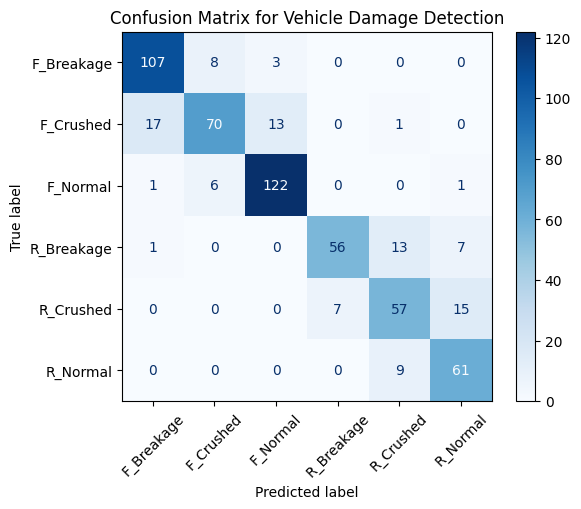

In [56]:
cm = confusion_matrix(all_labels,all_predictions)
disp = ConfusionMatrixDisplay(cm,display_labels = dataset.classes)
disp.plot(cmap = plt.cm.Blues, xticks_rotation = 45)
plt.title('Confusion Matrix for Vehicle Damage Detection')
plt.show()

In [57]:
torch.save(model.state_dict(),'car_model.pth')